# Segmentation

The purpose of segmentation is to separate the background from the objects of interest. Segmentation becomes significantly harder when objects are overlapped.

In [38]:
# Imports
import scipy.misc
import numpy as np
import numpy.ma
import numpy.random
from matplotlib import pyplot as plt
from functools import partial

In [2]:
# Manifest Constants
IMAGE_PATH = '../images/key.jpg'

In [3]:
color_image_data = scipy.misc.imread(IMAGE_PATH)
gray_image_data = scipy.misc.imread(IMAGE_PATH, mode='L')

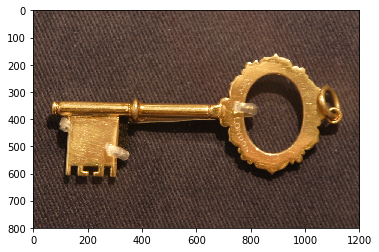

In [4]:
plt.imshow(color_image_data)

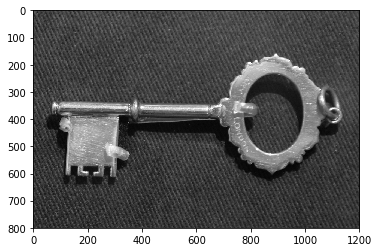

In [5]:
plt.imshow(gray_image_data, cmap='gray')

One of the approaches in the book is to "binarize" the images given some threshold.

In [6]:
def binarize(image_data, threshold, low=0, high=255):
    '''Returns the binarization of an ndarray containing an
    image's pixel intensities, i.e. returns an ndarray of
    the same dimensions as IMAGE_DATA, where all the element
    values are either LOW or HIGH, depending on whether the
    corresponding element in the origial IMAGE_DATA is lower
    than, or greater than the given THRESHOLD.
    
    >>>data = np.array([243, 3],
                        [245, 2])
    >>>binarize(dadta, threshold=200)
    array([255, 0],
            [255, 0])'''
    return np.vectorize(lambda el: high if el > threshold else low)(image_data)

Now the issue becomes about how to determine the threshold.

## Automatic thresholding

### Method based on the mode

With this method we work under the assumption that if we plot the histogram of the pixel intensities of an image's data, we will see two modes. One for the most common intensity value for the background, and the other for the most common value of the objects in the foreground.

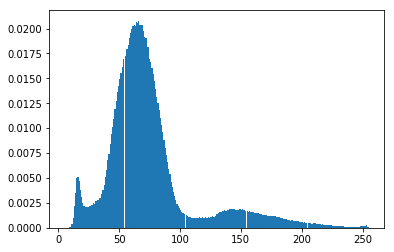

In [7]:
n, bins, patches = plt.hist(gray_image_data.ravel(), bins=255, normed=True)

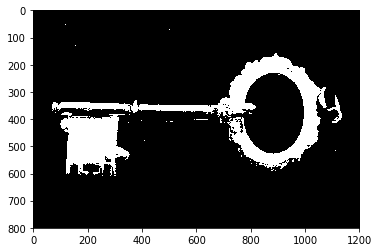

In [8]:
threshold = 120
result = binarize(gray_image_data, threshold)
plt.imshow(result, cmap='gray')

### Iterative method

1. Select an initial threshold. The average is a good candiate.
2. Segment the image in two sections based on the threshold.
3. Calculate the mean values of each of the segmented regions.
4. Improve the threshold to be the average of the two new thresholds.
5. Repeat steps two to four untill convergence.

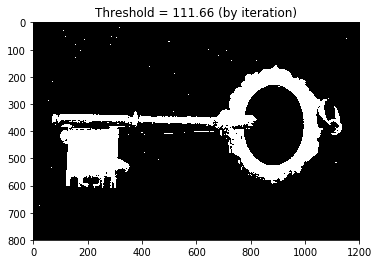

In [9]:
def iterative_threshold(image_data, convergence_delta=1):
    '''Return a threshold for image binarization. The
    threshold is calculated using the iterative
    method:
    
    1. Select an initial threshold. The average is good.
    2. Segment the image in two sections based on the threshold.
    3. Calculate the mean values of each of the segmented regions.
    4. Improve the threshold to be the average of the two new thresholds.
    5. Repeat steps two to four untill convergence.'''
    old_threshold = None
    threshold = image_data.mean()
    num_pixels = len(image_data.ravel())
    delta = 65536 # Impossibly high value
    while delta > convergence_delta:
        binarization = binarize(image_data, threshold=threshold, low=False, high=True)
        # Use the binarization as a mask to isolate the pixel values that
        # ended up in each of the segments
        segment_1 = np.trim_zeros(np.ma.array(image_data, mask=binarization).ravel())
        segment_1_mean = segment_1.mean()
        # Negate the binarization to use as a mask for the other segment
        not_binarization = np.vectorize(lambda x: not x)(binarization)
        segment_2 = np.trim_zeros(np.ma.array(image_data, mask=not_binarization).ravel())
        segment_2_mean = segment_2.mean()
        old_threshold = threshold
        threshold = np.mean((segment_1_mean, segment_2_mean))
        delta = abs(threshold - old_threshold)
    return threshold


threshold = iterative_threshold(gray_image_data)
result = binarize(gray_image_data, threshold=threshold)

plt.figure()
plt.title('Threshold = {:4.2f} (by iteration)'.format(threshold))
plt.imshow(result, cmap='gray')

### Adaptive method


The idea of the adaptive method is that we subdivide an image into smaller images (what we call `image_pieces`), binarize those pieces on their own, and then stitch the image back together. The algorithm is:


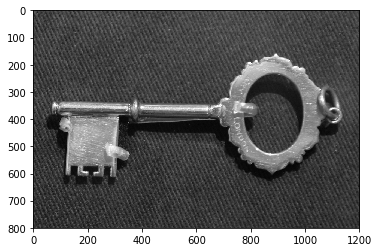

In [10]:
def image_to_pieces(image_data, piece_dimension):
    '''Given an IMAGE_DATA ndarray (asummed to be bidimensional)
    break it into a list of smaller ndarrays such that
    there are NUM_ROWS * NUM_COLS pieces and that all
    the pieces together form a non overlapping partition
    of IMAGE_DATA.'''
    shape = image_data.shape
    image_rows = shape[0]
    image_cols = shape[1]
    piece_rows = piece_dimension[0]
    piece_cols = piece_dimension[1]
    pieces = []
    for i in range(image_rows // piece_rows):
        for j in range(image_cols // piece_cols):
            pieces.append(image_data[i * piece_rows:(i+1) * piece_rows,
                                     j * piece_cols:(j+1) * piece_cols].copy())
    
    return pieces

def pieces_to_image(image_pieces, pieces_per_row):
    '''Returns an ndarray that is the image data of the
    given IMAGE_PIECES (ndarrays). PIECES_PER_ROW is the
    number of pieces that fit per row'''
    image_rows = [np.hstack(image_pieces[i*pieces_per_row:(i+1)*pieces_per_row]) for i in range(4)]
    return np.vstack(image_rows)

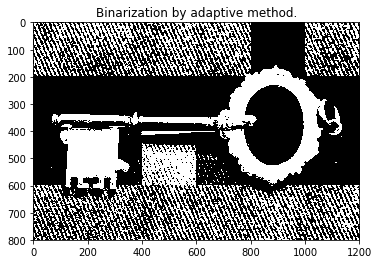

In [32]:
image_pieces = image_to_pieces(gray_image_data, (200, 200))
pieces_thresholds = list(map(iterative_threshold, image_pieces))
binarized_pieces = [binarize(image_pieces[i], pieces_thresholds[i]) for i in range(len(image_pieces))]
stitched_image = pieces_to_image(binarized_pieces, 6)
plt.figure()
plt.title('Binarization by adaptive method.')
plt.imshow(stitched_image, cmap='gray')

We can see in the output the effect of having pieces of the image where no part of the object was included.

### Otsu's Method

Otsu's method assumes that the pixels of an image $f(x,y)$ can be separated by using a threshold in those clasess: $C_1$, an object of interest class and $C_2$, the background.

Let:


$r$ be the level of intensity of a pixels with coordinates $f(x,y)$.

$L$ be the total number of levels of intensity for all pixels $f(x,y)$, with $0 \leq r \leq L-1$.

$p_r$ is the number of pixels that actually have the intensity level $r$.

$N_T = p_0 + p_1 + \ldots + p_r + \ldots + p_{L-1}$ is the total number of pixels.

$p(r) = \frac{p_r}{N_T}$ is the normalized histogram of grayscale intensities of $N_T$.

Otsu's method wants to maximize the function $J_3 (r)$ such that
$u* = \text{arg max } J_3 (r)$ s.t. $0 \leq r \leq L-1$

$$ \sigma^2 = \sum{i=0}^{L-1}

In [30]:
import numpy as np
from collections import Counter

def thresholding_otsu(image_data):
    '''This code was taken from
    https://en.wikipedia.org/wiki/Otsu%27s_method and slightly modified.'''
    nbins = 256
    pixel_counts  = Counter(image_data.ravel())
    counts = np.array([0 for x in range(256)])
    for c in sorted(pixel_counts):
        counts[c] = pixel_counts[c]
    p = counts/sum(counts)
    sigma_b = np.zeros((256,1))
    for t in range(nbins):
        q_L = sum(p[:t]) 
        q_H = sum(p[t:]) 
        if q_L ==0 or q_H == 0:
            continue
            
        miu_L = sum(np.dot(p[:t],np.transpose(np.matrix([i for i in range(t)]) )))/q_L
        miu_H = sum(np.dot(p[t:],np.transpose(np.matrix([i for i in range(t,256)]))))/q_H
        sigma_b[t] = q_L*q_H*(miu_L-miu_H)**2
        
    return np.argmax(sigma_b)

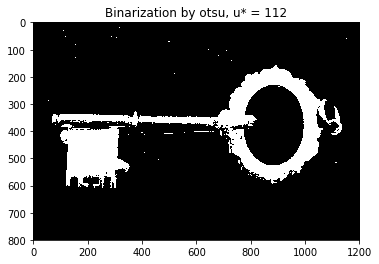

In [31]:
u_star = thresholding_otsu(gray_image_data)
result = binarize(gray_image_data, threshold=u_star)
plt.figure()
plt.title('Binarization by otsu, u* = {}'.format(u_star))
plt.imshow(result, cmap='gray')

### K-Means

"This is a prototype-based, partitional clustering technique that attempts to find a user-specified number of clusters (K), which are repesented by their centroids" (Tan, Steinbach, Kumar. 2006).

When using K-means for segmentation, instead of thinking about a threshold we think about clusters. One cluster would be the object or objects of interest while the other cluster would be the background (everything we are not interested in). The definition given in the previous paragraph states that the user specifies the number of clusters. For this simple segmentation we may use 2. When binarizing the image, instead of choosing the segment a pixels belongs to based on its relative position to a threshold, we associate the pixel with the segment whose mean (or centroid) it has the smallest distance to.

A simple algorithm for K-means is:

1.  Select $K$ points as the initial centroids
2.  repeat
3.  Form $K$ clusters by assigning each point to the closest centroid
4.  Recompute the centroid of each cluster (average)
5.  until centroids do not change (a.k.a have converged)

In [110]:
def kmeans_simple(data, num_clusters=2):
    '''
    '''
    centroids = np.random.choice(data, num_clusters)
    centroids_have_converged = False
    while not centroids_have_converged:
        prev_iter_centroids = centroids
        clusters = [list() for i in range(num_clusters)]
        for point in data:
            distances = np.absolute(centroids - point)
            clusters[np.argmin(distances)].append(point)
        centroids = np.array(list(map(np.mean, clusters)))
        centroid_differences = centroids - prev_iter_centroids
        centroids_have_converged = centroid_differences[np.where(centroid_differences > 2)].size == 0
    result = np.sort(centroids)
    return result

def binarize_kmeans(image_data, centroids):
    '''Binarizes the image ndarray IMAGE_DATA assigning
    its elements the value 0 or 255 depending on the centroid
    each element is closest to.'''
    return np.vectorize(lambda point: np.argmin(np.abs(centroids - point)) * 255)(image_data)

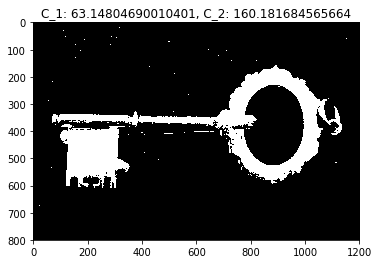

In [114]:
centroids = kmeans_simple(gray_image_data.ravel())
result = binarize_kmeans(gray_image_data, centroids)
plt.figure()
plt.title("C_1: {}, C_2: {}".format(centroids[0], centroids[1]))
plt.imshow(result, cmap='gray')

But now we are faced with one of the issues of the K-means method: how to choose the initial centroids. In our example above we chose them randomly, but notice that our final centroids may vary on each run. As an example let's run the exact same code three more times.

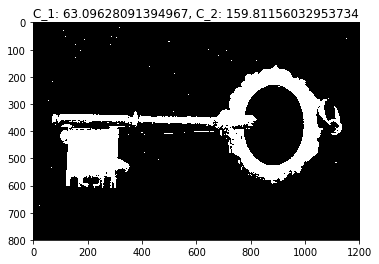

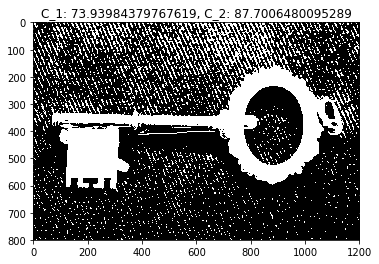

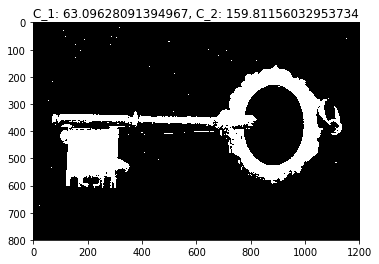

In [117]:
for i in range(3):
    centroids = kmeans_simple(gray_image_data.ravel())
    result = binarize_kmeans(gray_image_data, centroids)
    plt.figure()
    plt.title("C_1: {}, C_2: {}".format(centroids[0], centroids[1]))
    plt.imshow(result, cmap='gray')